In [1]:
!nvidia-smi

Thu Mar 14 18:08:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                  Off |
| N/A   32C    P0    29W / 150W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import gc
import os

def clear_gpu_memory(*args):
    """
    Clears specified PyTorch tensors or models from GPU memory, then clears the GPU memory cache.
    
    Args:
    *args: Variable length argument list. Expected to be PyTorch tensors or models.
    """
    # Attempt to delete each passed argument
    for arg in args:
        # Check if the argument is a tensor and is on GPU
        if isinstance(arg, torch.Tensor) and arg.is_cuda:
            # Delete the argument to release its GPU memory
            del arg
        # If it's a model or other structure with parameters
        elif hasattr(arg, 'parameters'):
            # Delete each parameter to release its GPU memory
            for param in arg.parameters():
                if param.is_cuda:
                    del param
    
    # Explicitly collect garbage
    gc.collect()
    
    # Empty the CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU memory cache has been emptied.")


In [3]:
#import transformer_lens

import sys

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer
from transformers import AutoTokenizer, pipeline, logging, AutoModelForCausalLM

from huggingface_hub import notebook_login
from datasets import Dataset
#imdb = load_dataset("parquet", data_files={'train': 'imdb/plain_text/train-00000-of-00001.parquet', 'test': 'imdb/plain_text/train-00000-of-00001.parquet'})
import pandas as pd
import transformers
import torch
import einops  # Make sure einops is imported

from neel_plotly import line, imshow, scatter
import transformer_lens.patching as patching
# Load CSV file with pandas
#df = pd.read_csv('imdb/IMDB Dataset.csv', nrows=15000)
# Convert the DataFrame to a Hugging Face Dataset
#dataset = Dataset.from_pandas(df)
import circuitsvis as cv

In [4]:
def load_HookededTransformer(model_type):
    if model_type=='Llama-7b':
        model_name = "../Models/Llama-2-7b-hf"
        model_basename = model_type
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        hf_model = AutoModelForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True)

        for param in hf_model.parameters():
             param.requires_grad = False
        # Move the model to evaluation mode to disable dropout, batchnorm etc., which are not needed during inference
        hf_model.eval()
        model = HookedTransformer.from_pretrained("llama-7b", hf_model=hf_model, tokenizer= tokenizer, device="cuda", dtype="float16")
    elif model_type=='Mistral-7b':
        model_name = "../Models/Mistral-7B-v0.1"
        model_basename = "Mistral"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        hf_model = AutoModelForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True)

        for param in hf_model.parameters():
             param.requires_grad = False
        # Move the model to evaluation mode to disable dropout, batchnorm etc., which are not needed during inference
        hf_model.eval()
        model = HookedTransformer.from_pretrained("llama-7b", hf_model=hf_model, tokenizer= tokenizer, device="cuda", dtype="float16")
    return model, tokenizer

# The head detector is from Nill Nanda's :  https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Head_Detector_Demo.ipynb#scrollTo=5ikyL8-S7u2Z

In [5]:


from collections import defaultdict
import logging
from typing import cast, Dict, List, Optional, Tuple, Union
from typing_extensions import get_args, Literal

import numpy as np
import torch

from transformer_lens import HookedTransformer, ActivationCache
# from transformer_lens.utils import is_lower_triangular, is_square

HeadName = Literal["previous_token_head", "duplicate_token_head", "induction_head"]
HEAD_NAMES = cast(List[HeadName], get_args(HeadName))
ErrorMeasure = Literal["abs", "mul"]

LayerHeadTuple = Tuple[int, int]
LayerToHead = Dict[int, List[int]]

INVALID_HEAD_NAME_ERR = (
    f"detection_pattern must be a Tensor or one of head names: {HEAD_NAMES}; got %s"
)

SEQ_LEN_ERR = (
    "The sequence must be non-empty and must fit within the model's context window."
)

DET_PAT_NOT_SQUARE_ERR = "The detection pattern must be a lower triangular matrix of shape (sequence_length, sequence_length); sequence_length=%d; got detection patern of shape %s"


def detect_head(
    model: HookedTransformer,
    seq: Union[str, List[str]],
    detection_pattern: Union[torch.Tensor, HeadName],
    heads: Optional[Union[List[LayerHeadTuple], LayerToHead]] = None,
    cache: Optional[ActivationCache] = None,
    *,
    exclude_bos: bool = False,
    exclude_current_token: bool = False,
    error_measure: ErrorMeasure = "mul",
) -> torch.Tensor:
    """Searches the model (or a set of specific heads, for circuit analysis) for a particular type of attention head.
    This head is specified by a detection pattern, a (sequence_length, sequence_length) tensor representing the attention pattern we expect that type of attention head to show.
    The detection pattern can be also passed not as a tensor, but as a name of one of pre-specified types of attention head (see `HeadName` for available patterns), in which case the tensor is computed within the function itself.

    There are two error measures available for quantifying the match between the detection pattern and the actual attention pattern.

    1. `"mul"` (default) multiplies both tensors element-wise and divides the sum of the result by the sum of the attention pattern.
    Typically, the detection pattern should in this case contain only ones and zeros, which allows a straightforward interpretation of the score:
    how big fraction of this head's attention is allocated to these specific query-key pairs?
    Using values other than 0 or 1 is not prohibited but will raise a warning (which can be disabled, of course).
    2. `"abs"` calculates the mean element-wise absolute difference between the detection pattern and the actual attention pattern.
    The "raw result" ranges from 0 to 2 where lower score corresponds to greater accuracy. Subtracting it from 1 maps that range to (-1, 1) interval,
    with 1 being perfect match and -1 perfect mismatch.

    **Which one should you use?** `"abs"` is likely better for quick or exploratory investigations. For precise examinations where you're trying to
    reproduce as much functionality as possible or really test your understanding of the attention head, you probably want to switch to `"abs"`.

    The advantage of `"abs"` is that you can make more precise predictions, and have that measured in the score.
    You can predict, for instance, 0.2 attention to X, and 0.8 attention to Y, and your score will be better if your prediction is closer.
    The "mul" metric does not allow this, you'll get the same score if attention is 0.2, 0.8 or 0.5, 0.5 or 0.8, 0.2.

    Args:
    ----------
        model: Model being used.
        seq: String or list of strings being fed to the model.
        head_name: Name of an existing head in HEAD_NAMES we want to check. Must pass either a head_name or a detection_pattern, but not both!
        detection_pattern: (sequence_length, sequence_length) Tensor representing what attention pattern corresponds to the head we're looking for **or** the name of a pre-specified head. Currently available heads are: `["previous_token_head", "duplicate_token_head", "induction_head"]`.
        heads: If specific attention heads is given here, all other heads' score is set to -1. Useful for IOI-style circuit analysis. Heads can be spacified as a list tuples (layer, head) or a dictionary mapping a layer to heads within that layer that we want to analyze.
        cache: Include the cache to save time if you want.
        exclude_bos: Exclude attention paid to the beginning of sequence token.
        exclude_current_token: Exclude attention paid to the current token.
        error_measure: `"mul"` for using element-wise multiplication (default). `"abs"` for using absolute values of element-wise differences as the error measure.

    Returns:
    ----------
    A (n_layers, n_heads) Tensor representing the score for each attention head.

    Example:
    --------
    .. code-block:: python

        >>> from transformer_lens import HookedTransformer,  utils
        >>> from transformer_lens.head_detector import detect_head
        >>> import plotly.express as px

        >>> def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
        >>>     px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

        >>> model = HookedTransformer.from_pretrained("gpt2-small")
        >>> sequence = "This is a test sequence. This is a test sequence."

        >>> attention_score = detect_head(model, sequence, "previous_token_head")
        >>> imshow(attention_score, zmin=-1, zmax=1, xaxis="Head", yaxis="Layer", title="Previous Head Matches")
    """

    cfg = model.cfg
    tokens = model.to_tokens(seq).to(cfg.device)
    seq_len = tokens.shape[-1]
    
    # Validate error_measure
    
    assert error_measure in get_args(ErrorMeasure), f"Invalid {error_measure=}; valid values are {get_args(ErrorMeasure)}"

    # Validate detection pattern if it's a string
    if isinstance(detection_pattern, str):
        assert detection_pattern in HEAD_NAMES, (
            INVALID_HEAD_NAME_ERR % detection_pattern
        )
        if isinstance(seq, list):
            batch_scores = [detect_head(model, seq, detection_pattern) for seq in seq]
            return torch.stack(batch_scores).mean(0)
        detection_pattern = cast(
            torch.Tensor,
            eval(f"get_{detection_pattern}_detection_pattern(tokens.cpu())"),
        ).to(cfg.device)

    # if we're using "mul", detection_pattern should consist of zeros and ones
    if error_measure == "mul" and not set(detection_pattern.unique().tolist()).issubset(
        {0, 1}
    ):
        logging.warning(
            "Using detection pattern with values other than 0 or 1 with error_measure 'mul'"
        )

    # Validate inputs and detection pattern shape
    assert 1 < tokens.shape[-1] < cfg.n_ctx, SEQ_LEN_ERR
    assert (
        is_lower_triangular(detection_pattern) and seq_len == detection_pattern.shape[0]
    ), DET_PAT_NOT_SQUARE_ERR % (seq_len, detection_pattern.shape)

    if cache is None:
        _, cache = model.run_with_cache(tokens, remove_batch_dim=True)

    if heads is None:
        layer2heads = {
            layer_i: list(range(cfg.n_heads)) for layer_i in range(cfg.n_layers)
        }
    elif isinstance(heads, list):
        layer2heads = defaultdict(list)
        for layer, head in heads:
            layer2heads[layer].append(head)
    else:
        layer2heads = heads

    matches = -torch.ones(cfg.n_layers, cfg.n_heads)

    for layer, layer_heads in layer2heads.items():
        # [n_heads q_pos k_pos]
        layer_attention_patterns = cache["pattern", layer, "attn"]
        for head in layer_heads:
            head_attention_pattern = layer_attention_patterns[head, :, :]
            head_score = compute_head_attention_similarity_score(
                head_attention_pattern,
                detection_pattern=detection_pattern,
                exclude_bos=exclude_bos,
                exclude_current_token=exclude_current_token,
                error_measure=error_measure,
            )
            matches[layer, head] = head_score
    return matches


# Previous token head
def get_previous_token_head_detection_pattern(
    tokens: torch.Tensor,  # [batch (1) x pos]
) -> torch.Tensor:
    """Outputs a detection score for [previous token heads](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=0O5VOHe9xeZn8Ertywkh7ioc).

    Args:
      tokens: Tokens being fed to the model.
    """
    detection_pattern = torch.zeros(tokens.shape[-1], tokens.shape[-1])
    # Adds a diagonal of 1's below the main diagonal.
    detection_pattern[1:, :-1] = torch.eye(tokens.shape[-1] - 1)
    return torch.tril(detection_pattern)


# Duplicate token head
def get_duplicate_token_head_detection_pattern(
    tokens: torch.Tensor,  # [batch (1) x pos]
) -> torch.Tensor:
    """Outputs a detection score for [duplicate token heads](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=2UkvedzOnghL5UHUgVhROxeo).

    Args:
      sequence: String being fed to the model.
    """
    # [pos x pos]
    token_pattern = tokens.repeat(tokens.shape[-1], 1).numpy()

    # If token_pattern[i][j] matches its transpose, then token j and token i are duplicates.
    eq_mask = np.equal(token_pattern, token_pattern.T).astype(int)

    np.fill_diagonal(
        eq_mask, 0
    )  # Current token is always a duplicate of itself. Ignore that.
    detection_pattern = eq_mask.astype(int)
    return torch.tril(torch.as_tensor(detection_pattern).float())


# Induction head
def get_induction_head_detection_pattern(
    tokens: torch.Tensor,  # [batch (1) x pos]
) -> torch.Tensor:
    """Outputs a detection score for [induction heads](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=_tFVuP5csv5ORIthmqwj0gSY).

    Args:
      sequence: String being fed to the model.
    """
    duplicate_pattern = get_duplicate_token_head_detection_pattern(tokens)

    # Shift all items one to the right
    shifted_tensor = torch.roll(duplicate_pattern, shifts=1, dims=1)

    # Replace first column with 0's
    # we don't care about bos but shifting to the right moves the last column to the first,
    # and the last column might contain non-zero values.
    zeros_column = torch.zeros(duplicate_pattern.shape[0], 1)
    result_tensor = torch.cat((zeros_column, shifted_tensor[:, 1:]), dim=1)
    return torch.tril(result_tensor)


def get_supported_heads() -> None:
    """Returns a list of supported heads."""
    print(f"Supported heads: {HEAD_NAMES}")


def compute_head_attention_similarity_score(
    attention_pattern: torch.Tensor,  # [q_pos k_pos]
    detection_pattern: torch.Tensor,  # [seq_len seq_len] (seq_len == q_pos == k_pos)
    *,
    exclude_bos: bool,
    exclude_current_token: bool,
    error_measure: ErrorMeasure,
) -> float:
    """Compute the similarity between `attention_pattern` and `detection_pattern`.

    Args:
      attention_pattern: Lower triangular matrix (Tensor) representing the attention pattern of a particular attention head.
      detection_pattern: Lower triangular matrix (Tensor) representing the attention pattern we are looking for.
      exclude_bos: `True` if the beginning-of-sentence (BOS) token should be omitted from comparison. `False` otherwise.
      exclude_bcurrent_token: `True` if the current token at each position should be omitted from comparison. `False` otherwise.
      error_measure: "abs" for using absolute values of element-wise differences as the error measure. "mul" for using element-wise multiplication (legacy code).
    """
    assert is_square(
        attention_pattern
    ), f"Attention pattern is not square; got shape {attention_pattern.shape}"

    # mul

    if error_measure == "mul":
        if exclude_bos:
            attention_pattern[:, 0] = 0
        if exclude_current_token:
            attention_pattern.fill_diagonal_(0)
        score = attention_pattern * detection_pattern
        return (score.sum() / attention_pattern.sum()).item()

    # abs

    abs_diff = (attention_pattern - detection_pattern).abs()
    assert (abs_diff - torch.tril(abs_diff).to(abs_diff.device)).sum() == 0

    size = len(abs_diff)
    if exclude_bos:
        abs_diff[:, 0] = 0
    if exclude_current_token:
        abs_diff.fill_diagonal_(0)

    return 1 - round((abs_diff.mean() * size).item(), 3)


In [6]:
# Util for plotting head detection scores

def plot_head_detection_scores(
    scores: torch.Tensor,
    zmin: float = -1,
    zmax: float = 1,
    xaxis: str = "Head",
    yaxis: str = "Layer",
    title: str = "Head Matches"
) -> None:
    imshow(scores, zmin=zmin, zmax=zmax, xaxis=xaxis, yaxis=yaxis, title=title)

def plot_attn_pattern_from_cache(cache: ActivationCache, layer_i: int):
    attention_pattern = cache["pattern", layer_i, "attn"].squeeze(0)
    attention_pattern = einops.rearrange(attention_pattern, "heads seq1 seq2 -> seq1 seq2 heads")
    print(f"Layer {layer_i} Attention Heads:")
    return pysvelte.AttentionMulti(tokens=model.to_str_tokens(prompt), attention=attention_pattern)


def is_square(x: torch.Tensor) -> bool:
    """Checks if `x` is a square matrix."""
    return x.ndim == 2 and x.shape[0] == x.shape[1]

def is_lower_triangular(x: torch.Tensor) -> bool:
    """Checks if `x` is a lower triangular matrix."""
    if not is_square(x):
        return False
    return x.equal(x.tril())

In [7]:
get_supported_heads()

Supported heads: ('previous_token_head', 'duplicate_token_head', 'induction_head')


In [8]:
torch.set_grad_enabled(False)
model, tokenizer = load_HookededTransformer(model_type='Llama-7b')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model llama-7b into HookedTransformer


# Finding the previous head matches

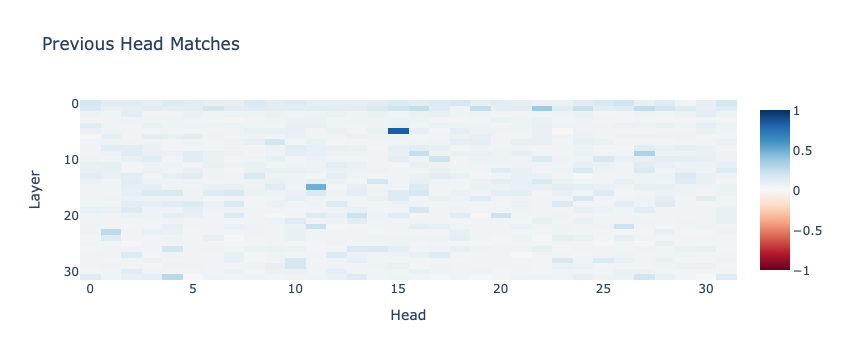

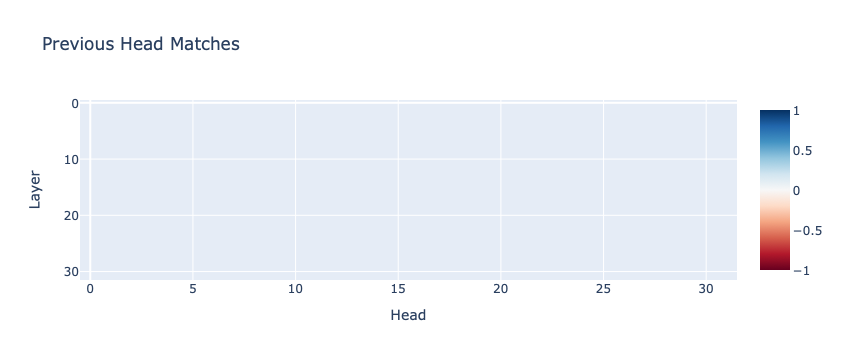

In [41]:
prompt = "The head detector feature for TransformerLens allows users to check for various common heads automatically, reducing the cost of discovery."
head_scores = detect_head(model, prompt, "previous_token_head")
plot_head_detection_scores(head_scores, title="Previous Head Matches")
head_scores = detect_head(model, prompt, "previous_token_head", exclude_bos=True, exclude_current_token=True)
plot_head_detection_scores(head_scores, title="Previous Head Matches")

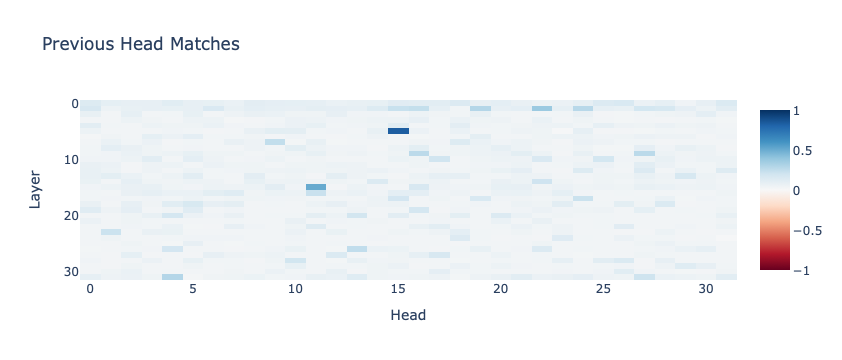

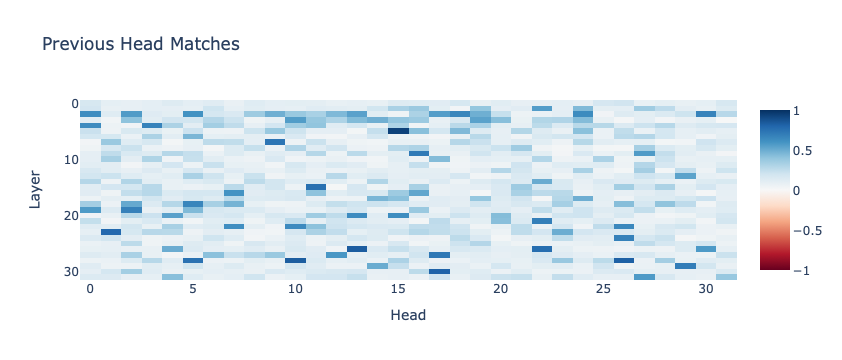

In [40]:
prompt = "Man I can understand how it might be Kinda hard to love a girl like me I don't blame you much for wanting to be free I just wanted you to know"
head_scores = detect_head(model, prompt, "previous_token_head")
plot_head_detection_scores(head_scores, title="Previous Head Matches")
head_scores = detect_head(model, prompt, "previous_token_head", exclude_bos=True, exclude_current_token=True)
plot_head_detection_scores(head_scores, title="Previous Head Matches")

In [11]:
_, cache = model.run_with_cache(prompt)

In [12]:
layer_idx=5
cv.attention.attention_patterns(
            tokens=model.to_str_tokens(prompt),
            attention=cache["pattern",layer_idx,"attn"].squeeze(0)# Add a dummy axis, as CircuitsVis expects 3D patterns.
        )

In [13]:
layer_idx=15

cv.attention.attention_patterns(
            tokens=model.to_str_tokens(prompt),
            attention=cache["pattern",layer_idx,"attn"].squeeze(0)# Add a dummy axis, as CircuitsVis expects 3D patterns.
        )

# Duplicated token

In [50]:
prompts = [
    "one two three one two three one two three",
    "1 2 3 4 5 1 2 3 4 1 2 3 1 2 3 4 5 6 7",
    "green ideas sleep furiously; green ideas don't sleep furiously"
]

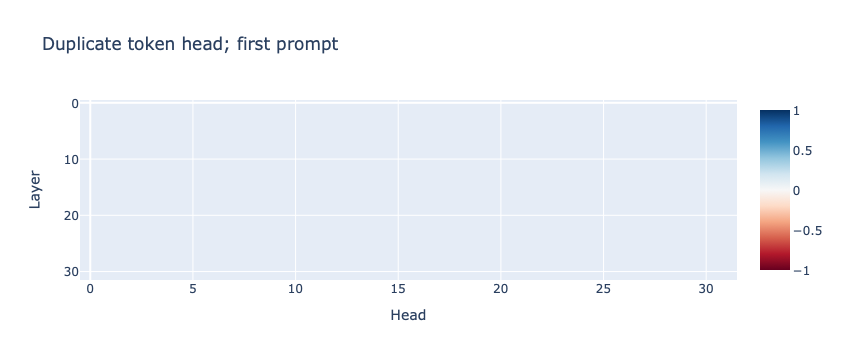

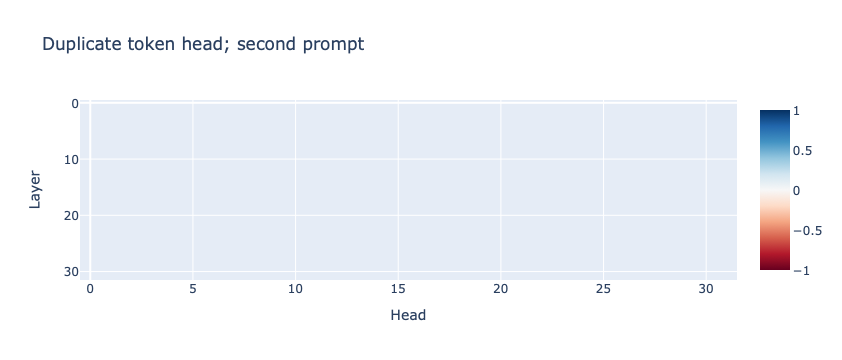

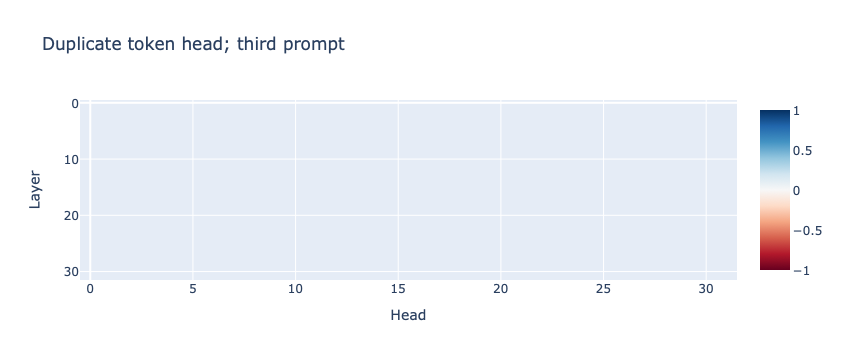

In [59]:
head_scores = detect_head(model, [prompts[0]], "duplicate_token_head", exclude_bos=False, exclude_current_token=False, error_measure="abs")
plot_head_detection_scores(head_scores, title="Duplicate token head; first prompt")
head_scores = detect_head(model, [prompts[1]], "duplicate_token_head", exclude_bos=False, exclude_current_token=False, error_measure="abs")
plot_head_detection_scores(head_scores, title="Duplicate token head; second prompt ")
head_scores = detect_head(model, [prompts[2]], "duplicate_token_head", exclude_bos=False, exclude_current_token=False, error_measure="abs")
plot_head_detection_scores(head_scores, title="Duplicate token head; third prompt")

In [66]:
_, cache = model.run_with_cache(prompts[0])
layer_idx=8

cv.attention.attention_patterns(
            tokens=model.to_str_tokens(prompts[0]),
            attention=cache["pattern",layer_idx,"attn"].squeeze(0)# Add a dummy axis, as CircuitsVis expects 3D patterns.
        )

# induction heads

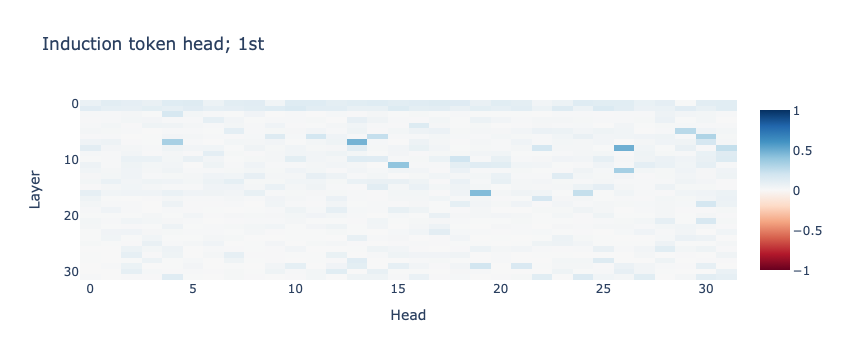

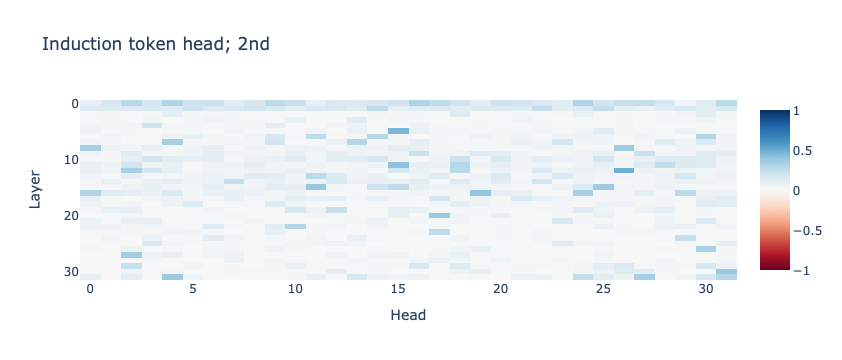

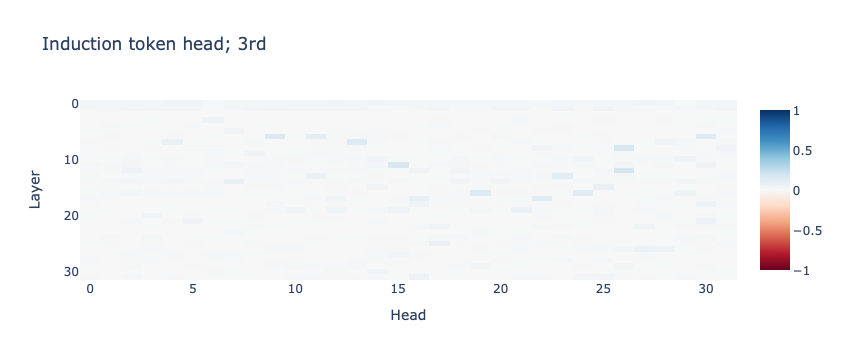

In [71]:
head_scores = detect_head(model, [prompts[0]], "induction_head", exclude_bos=False, exclude_current_token=False, error_measure="abs")
plot_head_detection_scores(head_scores, title="Induction token head; 1st")
head_scores = detect_head(model, [prompts[1]], "induction_head", exclude_bos=False, exclude_current_token=False, error_measure="abs")
plot_head_detection_scores(head_scores, title="Induction token head; 2nd")
head_scores = detect_head(model, [prompts[2]], "induction_head", exclude_bos=False, exclude_current_token=False, error_measure="abs")
plot_head_detection_scores(head_scores, title="Induction token head; 3rd")

In [73]:
_, cache = model.run_with_cache(prompts[0])
layer_idx=7

cv.attention.attention_patterns(
            tokens=model.to_str_tokens(prompts[0]),
            attention=cache["pattern",layer_idx,"attn"].squeeze(0)# Add a dummy axis, as CircuitsVis expects 3D patterns.
        )

In [14]:
batch = 4
seq_len = 20
rand_tokens_A = torch.randint(100, 10000, (batch, seq_len)).to(model.cfg.device)
rand_tokens_B = torch.randint(100, 10000, (batch, seq_len)).to(model.cfg.device)
rand_tokens_C = torch.randint(100, 10000, (batch, seq_len)).to(model.cfg.device)
bos = torch.tensor([model.tokenizer.bos_token_id]*batch)[:, None].to(model.cfg.device)
clean_tokens_induction = torch.cat([bos, rand_tokens_A, rand_tokens_A], dim=1).to(model.cfg.device)
corrupted_tokens_induction = torch.cat([bos, rand_tokens_A, rand_tokens_B], dim=1).to(model.cfg.device)


In [15]:
clean_logits_induction, clean_cache_induction = model.run_with_cache(clean_tokens_induction)
corrupted_logits_induction, corrupted_cache_induction = model.run_with_cache(corrupted_tokens_induction)

In [16]:
def induction_loss(logits, answer_token_indices=rand_tokens_A):
    seq_len = answer_token_indices.shape[1]

    # logits: batch x seq_len x vocab_size
    # Take the logits for the answers, cut off the final element to get the predictions for all but the first element of the answers (which can't be predicted)
    final_logits = logits[:, -seq_len:-1]
    final_log_probs = final_logits.log_softmax(-1)
    return final_log_probs.gather(-1, answer_token_indices[:, 1:].unsqueeze(-1)).mean()
CLEAN_BASELINE_INDUCTION = induction_loss(clean_logits_induction).item()
print("Clean baseline:", CLEAN_BASELINE_INDUCTION)
CORRUPTED_BASELINE_INDUCTION = induction_loss(corrupted_logits_induction).item()
print("Corrupted baseline:", CORRUPTED_BASELINE_INDUCTION)

Clean baseline: -0.63232421875
Corrupted baseline: -10.4296875


In [17]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(model, corrupted_tokens_induction, clean_cache_induction, induction_loss)
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head (All Pos)", xaxis="Head", yaxis="Layer", zmax=CLEAN_BASELINE_INDUCTION)



  0%|          | 0/1024 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Ensure the directory exists
directory = 'figure/playground_4/'
if not os.path.exists(directory):
    os.makedirs(directory)

# Assuming every_head_all_pos_act_patch_result is your tensor and already in CPU
filename = os.path.join(directory, 'case_induction_every_head_all_pos_act_patch_result.pt')
torch.save(every_head_all_pos_act_patch_result.cpu(), filename)

In [ ]:
corrupted_tokens_induction_BA = torch.cat([bos, rand_tokens_B, rand_tokens_A], dim=1).to(model.cfg.device)
corrupted_tokens_induction_BB = torch.cat([bos, rand_tokens_B, rand_tokens_B], dim=1).to(model.cfg.device)
corrupted_tokens_induction_BC = torch.cat([bos, rand_tokens_B, rand_tokens_C], dim=1).to(model.cfg.device)

In [ ]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(model, corrupted_tokens_induction_BA, clean_cache_induction, induction_loss)
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head on BA (All Pos)", xaxis="Head", yaxis="Layer", zmax=CLEAN_BASELINE_INDUCTION)

# Assuming every_head_all_pos_act_patch_result is your tensor and already in CPU
filename = os.path.join(directory, 'case_induction_every_head_all_pos_act_patch_result_BA.pt')
torch.save(every_head_all_pos_act_patch_result.cpu(), filename)

every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(model, corrupted_tokens_induction_BB, clean_cache_induction, induction_loss)
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head on BB (All Pos)", xaxis="Head", yaxis="Layer", zmax=CLEAN_BASELINE_INDUCTION)

# Assuming every_head_all_pos_act_patch_result is your tensor and already in CPU
filename = os.path.join(directory, 'case_induction_every_head_all_pos_act_patch_result_BB.pt')
torch.save(every_head_all_pos_act_patch_result.cpu(), filename)

every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(model, corrupted_tokens_induction_BC, clean_cache_induction, induction_loss)
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head on BC (All Pos)", xaxis="Head", yaxis="Layer", zmax=CLEAN_BASELINE_INDUCTION)

# Assuming every_head_all_pos_act_patch_result is your tensor and already in CPU
filename = os.path.join(directory, 'case_induction_every_head_all_pos_act_patch_result_BC.pt')
torch.save(every_head_all_pos_act_patch_result.cpu(), filename)